In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

total_pattern = re.compile('(\S+)\s+(\S+)')
pattern = re.compile('(\S+)\s+(\S+)\s+(\S+)')

In [2]:
feats = pd.read_csv("../System/fake_news_feats_train.csv")
fake = feats.loc[feats['class'] == 1]
real = feats.loc[feats['class'] == 0]

feats.head()

,index,superlatives,degree_adverbs,comparative_adverbs,proper_nouns,dates,numbers,fp_pronouns,negations,pos_emotion,...,ap_num,ap_date,ap_title,alliteration,profanity,lexical_diversity,lexical_density,function_words,spelling_errors,class
0,1,0.012270,0.100000,0.100000,0.297297,0.000000,0.012270,0.357143,0.006135,0.000000,...,0.0,0.0,1.0,0.142857,0.000000,0.735294,0.576471,0.423529,0.052941,1
1,2,0.002611,0.130435,0.043478,0.226415,0.005222,0.007833,0.041667,0.007833,0.002611,...,0.0,0.0,1.0,0.111111,0.000000,0.612245,0.579082,0.420918,0.028061,1
2,3,0.000000,0.000000,0.000000,0.209677,0.000000,0.010101,0.600000,0.000000,0.005051,...,0.0,0.0,0.0,0.000000,0.000000,0.706731,0.610577,0.389423,0.014423,1
3,4,0.000000,0.250000,0.000000,0.400000,0.003968,0.003968,0.111111,0.003968,0.000000,...,0.0,0.0,1.0,0.181818,0.003802,0.627376,0.653992,0.346008,0.045627,1
4,5,0.000000,0.125000,0.000000,0.226190,0.010989,0.030220,0.137931,0.016484,0.013736,...,1.0,0.0,1.0,0.222222,0.002681,0.563003,0.560322,0.439678,0.037534,1


In [3]:
superlatives = r'DAT|JJT|RGT|RRT'
degree_adverbs = r'RG(QV?|R|T)?'
comparative_adverbs = r'RGR|RRR'
proper_nouns = r'NP[12]'
dates = r'NP(D[12]|M[12])'
numbers = r'M[CDF]\w*'
fp_pronouns = r'PPI\w+'
negations = r'XX'

all_emotion = r'E[\w\.\+-]+'
emotion_general = r'E1[\+-]'
pos_emotion = r'E[2-6](\.[12])?\++'
neg_emotion = r'E[2-6](\.[12])?-+'
time_related = r'T[1-4][\.\d\+-]*'
sense_words = r'X3[\.\d\+-]*'
movement_words = r'M[1-6]'
relationships = r'S3.*'

spatial_words = r'RL|ND1|NNL[12]|M[78]'

# Imagination subject to change
inf_conjunctions = r'CC'
ima_conjunctions = r'CCB|CS'
conjunctions = r'C\w+'
inf_verb = r'VVN'
ima_verb = r'VV[^N]\w?|VM'
verbs = r'V\w+'
prepositions = r'I\w+'
articles = r'A\w+'
ima_determiners = r'DA1|DB\w?'
determiners = r'D\w+'
adjectives = r'J\w+'
nouns = r'N\w+'
pronouns = r'P\w+'
adverbs = r'R\w+'

exaggeration = r'A13\.[237]'    # Boosters, Maximisers, and Minimisers.
vague_degree = r'A13\.[145]'    # Non-specific, Approximators, Compromisers

re_punctuation = r'[\.\,\"\'\“\”\`\!\?]+'

In [4]:
def find_punctuation(indices):
    counts = dict()
    for i in indices:
        with open("../Tagged_Fake_News/{0}h/{0}h.txt".format(i)) as pos_file:
            text = pos_file.read().strip()
            instances = re.findall(re_punctuation, text)
            for p in instances:
                if p in counts:
                    counts[p] += (1 / len(text) / len(indices) * 100)
                else:
                    counts[p] = (1 / len(text) / len(indices) * 100)
                    
    return counts

def find_common_tags(regex, indices):
    directory = "../Tagged_Corpus"
    tags = dict()
    for i in indices:
        with open("../Tagged_Fake_News/{0}/{0}.txt.pos.sem.wap.fql".format(i)) as pos_file:
            lines = [line.strip() for line in pos_file]
            t = total_pattern.match(lines[0])
            total = int(t.group(2).strip())
            for line in lines:
                curr = line.strip()
                m = pattern.match(curr)
                
                if not m: continue
                
                word = m.group(1)
                tag = m.group(2)
                count = int(m.group(3)) / total / len(indices) * 100
                
                if tag in tags:
                    tags[tag].append((word, count))
                else:
                    tags[tag]= [(word, count)]
                        
        with open("../Tagged_Fake_News/{0}/{0}.txt.pos.sem.was.fql".format(i)) as sem_file:
            lines = [line.strip() for line in sem_file]
            t = total_pattern.match(lines[0])
            total = int(t.group(2).strip())
            for line in lines:
                curr = line.strip()
                m = pattern.match(curr)
                
                if not m: continue
                
                word = m.group(1)
                tag = m.group(2)
                count = int(m.group(3)) / total / len(indices) * 100
                
                if tag in tags:
                    tags[tag].append((word, count))
                else:
                    tags[tag]= [(word, count)]
                    
        words = []
        for tag in tags:
            if re.fullmatch(regex, tag):
                for word in tags[tag]:
                    words.append(word)
                        
    return words

In [14]:
target_tag = time_related
target_tag

'T[1-4][\\.\\d\\+-]*'

In [15]:
fake_words = find_common_tags(target_tag, fake.index.values + 1)

fake_words_pd = pd.DataFrame(fake_words, columns=['word','fake_count'])
fake_words_pd = fake_words_pd.groupby('word').sum()

fake_words_pd.sort_values("fake_count", ascending=False)

,fake_count
word,
will,0.340271
now,0.140739
former,0.125803
time,0.102929
new,0.101892
years,0.095029
sources,0.077962
today,0.072557
week,0.071174


In [16]:
real_words = find_common_tags(target_tag, real.index.values + 1)

real_words_pd = pd.DataFrame(real_words, columns=['word','real_count'])
real_words_pd = real_words_pd.groupby('word').sum()

real_words_pd.sort_values("real_count", ascending=False)

,real_count
word,
will,0.367701
former,0.165209
new,0.121108
now,0.102308
years,0.090951
going_to,0.084164
still,0.074521
time,0.069998
never,0.068779


In [17]:
word_freqs = fake_words_pd.join(real_words_pd, how='outer')
word_freqs = word_freqs.fillna(0)

word_freqs = word_freqs.sort_values("fake_count", ascending=False)
word_freqs

,fake_count,real_count
word,,
will,0.340271,0.367701
now,0.140739,0.102308
former,0.125803,0.165209
time,0.102929,0.069998
new,0.101892,0.121108
years,0.095029,0.090951
sources,0.077962,0.016771
today,0.072557,0.028998
week,0.071174,0.039932


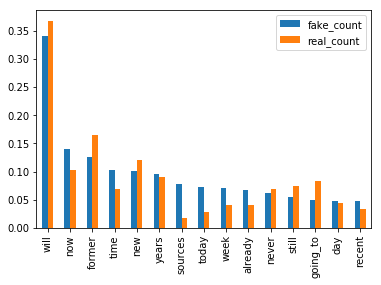

In [18]:
fig, ax = plt.subplots()

top_20 = word_freqs.head(15)
top_20.plot.bar(ax=ax)
ax.xaxis.label.set_visible(False)
plt.show()

In [19]:
fake_punct = find_punctuation(fake.index.values + 1)
real_punct = find_punctuation(real.index.values + 1)

In [20]:
fake_punct_pd = pd.DataFrame.from_dict(fake_punct, orient='index')
fake_punct_pd.columns = ['fake_count']
fake_punct_pd = af_punct_pd.sort_values('fake_count', ascending=False)

real_punct_pd = pd.DataFrame.from_dict(real_punct, orient='index')
real_punct_pd.columns = ['real_count']
real_punct_pd = real_punct_pd.sort_values('real_count', ascending=False)

punct_freqs = fake_punct_pd.join(real_punct_pd, how='outer')
punct_freqs = punct_freqs.fillna(0)

punct_freqs = punct_freqs.sort_values("fake_count", ascending=False)
punct_freqs

NameError: name 'af_punct_pd' is not defined

In [ ]:
punct_freqs.head(20).plot.bar()
plt.show()